# Introduction to Quantum Computing: From Fundamentals to Quantum Algorithms


**Part 1: Quantum Fourier Transform**

*(i) Introduction: The Power of Transformation*

Welcome to the first part of this assignment on the Quantum Fourier Transform (QFT). Before we dive into the fascinating world of quantum algorithms, let's understand why transforms are so crucial in computation and signal processing.

Transforms, at their core, convert a function from one domain to another, often revealing hidden patterns or simplifying complex operations. Think of it like looking at the same vector from different basis or the same object from different angles, each perspective can offer unique insights.

The Fourier Transform, arguably one of the most insightful mathematical transforms, takes a function from its original "time domain" (or spatial domain) and transforms it into the "frequency domain". In the frequency domain, we can see which frequencies are present in the original signal and with what amplitudes. It is a cornerstone of classical signal processing. To implement the Fourier Transform on digital computers we use its discrete counterpart, the Discrete Fourier Transform (DFT).

*(ii) Computational Complexity*

A naive implementation of the DFT takes $O(N^2)$ time. However, a highly optimized algorithm called the **Fast Fourier Transform (FFT)**, reduces this complexity significantly to $O(N \log N)$. This makes Fourier Analysis on computers computationally feasible for large datasets.

*(iii) The Quantum Leap: Quantum Fourier Transform (QFT)*

The Quantum Fourier Transform (QFT) is the quantum analogue of the DFT. While it performs a similar mathematical transformation, its implementation leverages the principles of quantum mechanics. The QFT, operating on $n = \log_2 N$ qubits, performs the transformation in $O(n^2)$ time, which is $O((\log N)^2)$ in terms of $N$. This exponential speedup from FFT is a cornerstone for many powerful quantum algorithms.

**Note:** It is crucial to understand that while QFT performs the transformation exponentially faster, the output is a quantum state. We cannot directly read all $N$ coefficients from this state simultaneously. Instead, we can sample from the distribution of outcomes, or use the QFT as a subroutine within a larger quantum algorithm.

In the subsequent cells of this part of the assignment, we will see how to implement QFT in practice, witnessing its magic firsthand!

In [110]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import numpy as np

Let's start by first implementing a basics QFT of the initial state $|0010\rangle$ and see if the output is what we expect.

In [111]:
# Step 1: Initialize a 4-qubit circuit with |0010⟩ state
qc = QuantumCircuit(4)

# Set the initial state: |0010⟩
qc.x(1)

qc.barrier(range(4))

In [112]:
for qubit in range(3,-1,-1):
    # Apply Hadamard to the current qubit
    qc.h(qubit)
    
    # Apply controlled rotations (R_k) on subsequent qubits
    for k in range(qubit):
        angle = 2 * np.pi / (2 ** (k + 2))
        qc.cp(angle, qubit - k -1, qubit)   # .cp is the controlled phase gate
    qc.barrier(range(4))
for i in range(4 // 2):
        qc.swap(i, 4 - 1 - i)

Note that the above implementation might seem incorrect as compared to what is shown in the book. For this remember the 2nd tutorial where we talked about the qubit sequence in qiskit being in reverse of the generally used convention

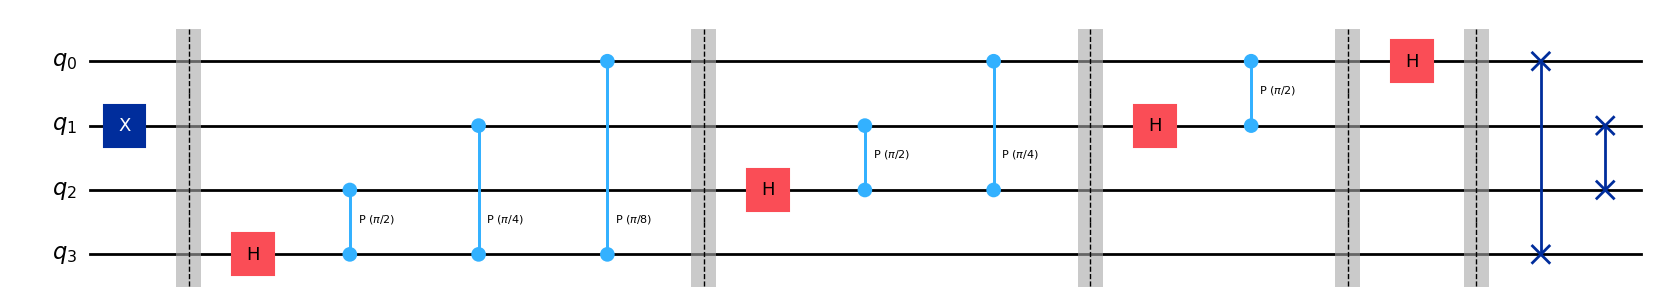

In [113]:
qc.draw('mpl')

Now, we can check if the circuit that we have made is correct by using `Statevector`

In [114]:
from qiskit.quantum_info import Statevector

# Set the initial state of the simulator to the ground state using from_int
state = Statevector.from_int(0, 2**4)

# Evolve the state by the quantum circuit
state = state.evolve(qc)

#draw using latex
state.draw('latex')

<IPython.core.display.Latex object>

In [115]:
# Step 3: Measure all qubits
qc.measure_all()

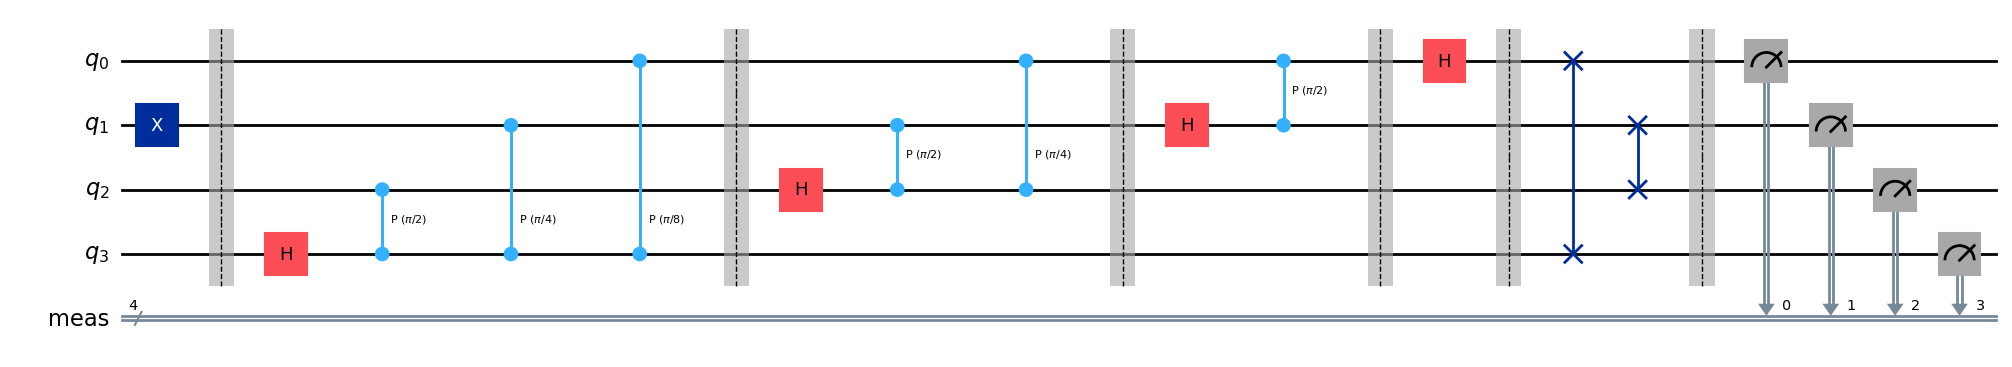

In [116]:
qc.draw('mpl', fold=-1)

We will exclusively be using AerSimulator to run our QFT circuit in this assignment. Also, note that ideally  we shouldn't put this much barrier in our circuit, as it affects the transpilation process when we run it on real device, but I have done so for your clarity.

In [ ]:
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)

In [47]:
result = simulator.run(compiled_circuit, shots=9600).result()

Measurement counts: {'0011': 604, '1100': 624, '0111': 611, '1010': 586, '0001': 610, '1001': 602, '1101': 615, '1011': 596, '0100': 601, '1110': 619, '1000': 590, '0110': 572, '0000': 608, '1111': 595, '0010': 545, '0101': 622}


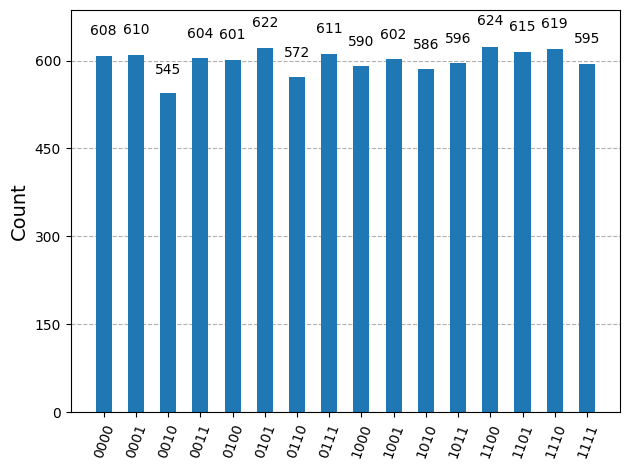

In [48]:
# Get and plot counts
counts = result.get_counts()
print("Measurement counts:", counts)
plot_histogram(counts)

As we can see, counts for each of the states are almost the same. This is what we expected, for all the outcomes to be equally probable. This is because the input is in a definite state ($|0010\rangle$) and we know that fourier transform of such state contains the equal superposition of all the frequency. For example find the FT of the $\psi(x) = \delta(x - x_0)$. The outcome is a constant function, i.e. all frequencies have equal superposition.

Now, we will see an easier way to implemet QFT, using the `QFT` class. Below we will try to implement it for $e^{2ix}$ and see if the results match the expectation. But first lets see if this method gives the same ouput statevector as the previous one

In [49]:
from qiskit.circuit.library import QFT

In [142]:
qft_circ = QFT(4, inverse=False)

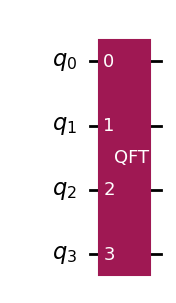

In [143]:
qft_circ.draw('mpl')

In [144]:
qft = QuantumCircuit(4)

qft.x(1)

qft = qft.compose(qft_circ)

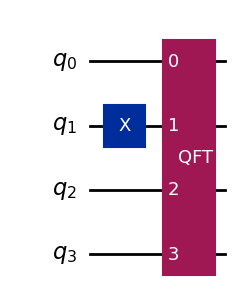

In [145]:
qft.draw('mpl')

In [146]:
# Set the initial state of the simulator to the ground state using from_int
state = Statevector.from_int(0, 2**4)

# Evolve the state by the quantum circuit
state = state.evolve(qft)

#draw using latex
state.draw('latex')

<IPython.core.display.Latex object>

This matches our previous answer. Now let's do the same for $e^{2ix}$

In [153]:
# Step 1: Discretize e^(2ix) into 2^4 = 16 points
n_qubits = 4
num_points = 2**n_qubits
x = np.linspace(0, 2*np.pi, num_points, endpoint=False)
func_values = np.exp(1j*2*x)

# Normalize the values to fit as amplitudes
normalized_values = func_values / np.linalg.norm(func_values)

In [154]:
# Step 2: Encode the normalized values into a quantum state
qc_exp = QuantumCircuit(n_qubits)
qc_exp.initialize(normalized_values, range(n_qubits))

In [155]:
qft_circ_inv = QFT(4, inverse=True)

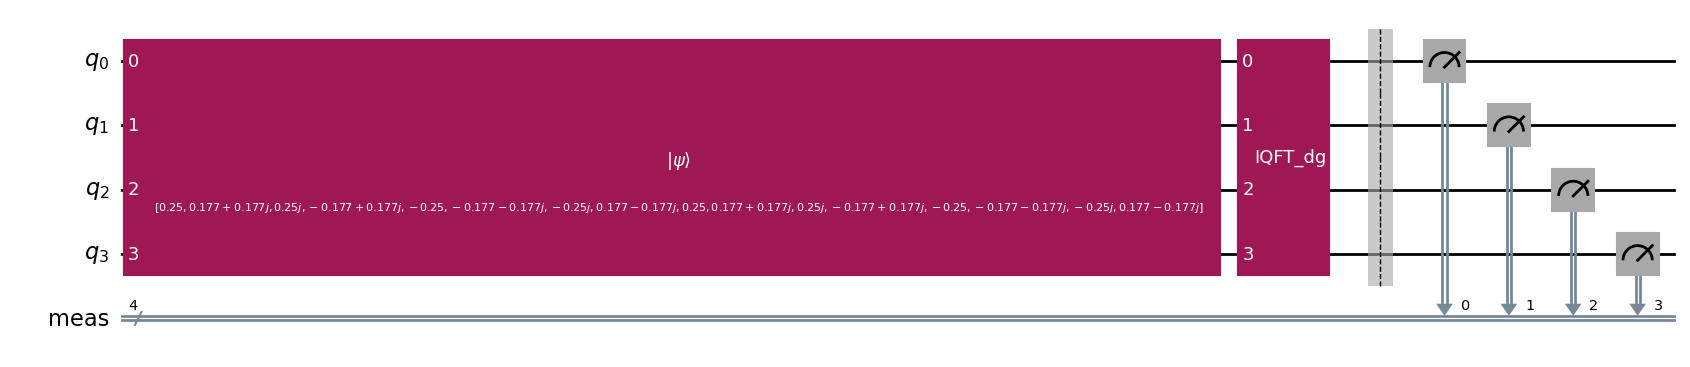

In [156]:
qc_exp.compose(qft_circ_inv, inplace=True)
qc_exp.measure_all()
qc_exp.draw('mpl')

In [157]:
qc_exp_comp = transpile(qc_exp, simulator)

In [158]:
result = simulator.run(qc_exp_comp, shots=9600).result()

Measurement counts: {'0010': 9600}


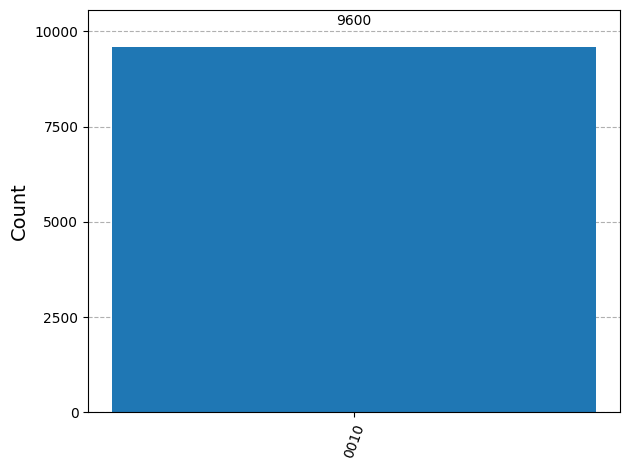

In [159]:
# Get and plot counts
counts = result.get_counts()
print("Measurement counts:", counts)
plot_histogram(counts)

Cool, as we can see that the outcome matches our expectations. QFT has detected that the only frequncy present in the function is 2 $\equiv |0010\rangle$. Now comes the problems related to the first part of our assignment.

*Problems*
1. In the implementation of QFT for $|0010\rangle$ we use `QFT(4, inverse=False)` but in the second part we use `QFT(4, inverse=True)` to find the frequency of the function. Give a good explainantion as to why we have to use inverse QFT for finding freq. of e^2ix.
2. Implement Fourier Transform of $sin(2x)$ and $sin(8x)$ similarly as to what I have done for $e^{2ix}$ and plot the histogram of the results.
3. The histogram for $sin(2x)$ shows peaks at 2 and 14. Explain why this makes sense theoretically, especially the peak at 14.
4. The histogram for $sin(8x)$ shows expected peak at 8 but this the plot has a distict different pattern (small peaks at other frequencies). This was not observed for either $e^{2ix}$ or $sin(2x)$. There is a very profound reason for this, please do some detailed research on this (maybe you find some insights related to the core principles behind DFT itself, be it classical one or its quantum counterpart). Give a detailed explaination for this pattern (Please dont write due to error, we are using noiseless AerSimulator for this).
5. The method I have used above to load a function onto a quantum state is called Amplitude Encoding. It is a technique used in quantum computing to represent classical data within the amplitudes of a quantum state but it is often not considered optimal for practical applications. Give an explainantion as to why this is the case and also briefly describe 1-2 alternatives for this that can be used. (I was planning to include such alternatives in the next assignment but I might not be able to due to time constraints, but still these are used in the latest cutting edge algoritms/research and you should atleast know of them)

(Answers directly copied from AI tools will not be considered. Please try to spend a bit of time researching on this on your own, this will be a good learning experience.)

**Part 2: Quantum Phase Estimation**

In the previous part I provided tutorial on how to implement QFT and the assignmnet was just to replicate my results for a different function and explain the output. Since, you all have sufficent experience in implementing algorithms on qiskit and have had plenty of time to read the theory of QPE, I will be doing something different for this part. In this part I expect you to implement the QPE algorithm as you studied in the Neilsen and Chuang book on your own.

*Problem - Estimating Excited State Energy of a Quantum Material for Battery Design using Quantum Phase Estimation algo.*

You are part of a quantum modeling team, investigating a novel quantum material with potential applications in solid-state batteries. This material exhibits quantum behavior that significantly increases its energy storage capacity and stability. Now, understanding the energy spectrum of the system is critical for predicting its properties and chemical stability. Your team has modeled the system's active site using a simplified two-level Hamiltonian. Estimating the first excited state energy of this system is your immediate task and all you know is that it's value is less than 4 units . Due to the quantum nature of the system and its sensitivity, you decide to use Quantum Phase Estimation (QPE) to obtain precise energy eigenvalues. The Hamiltonian in question is of the form $H = \begin{bmatrix} 0 & 0 \\ 0 & \theta \end{bmatrix}$. Now, we know that the ground state energy, i.e. energy corresponding to $|0\rangle$ is 0. Our job is to find $\theta$ corresponding to $|1\rangle$. To keep the problem interesting, even while simulating the scenario on a classical machine, I have given you an encrypted theta file containing the value of $\theta$ so that I don't spoil the answer to those who are excited for solving this question. Follow the steps below and find the value of the first excited state energy of the given Hamiltonian.

1. Once we have $H$, we can form $U = e^{2\pi iH}$. Since $H$ is diagonal, the eigenvalues of U is $e^0$ and $e^{2\pi i\theta}$. Now, we can use the good ol' QPE algorithm to find $\theta$. Notice that $U$ has the form of a phase gate, so you can directly implement the U gate from the code given in the below cell. But wait a second, why do we use $\phi = 2\pi \theta / 4$? where does this 4 come from? All we can connect this 4 to is that we know that $\theta$ is less than 4. But why do we divide by 4. Explain the reason why we do this in a markdown cell
2. Implement the QPE circuit to find the phase of U for the eigenvector $|1\rangle$. You can use the book for your reference on what steps shoud be taken
3. Find the values of the phase and multiply it by 4 to get the value of $\theta$

**Hint for question 1**: Remember that $e^{2\pi i2.2} = e^{2\pi i0.2}$, so what exactly does QPE measure when we run it for this eigenvalue


In [172]:
import base64

with open("theta.txt", "r") as f:
    encoded_theta = f.read()

theta = float(base64.b64decode(encoded_theta).decode())
phi = (2 * np.pi * theta) / 4

# You can implement controlled U^(2^j) as follows:
qc_qpe = QuantumCircuit(2)
qc_qpe.x(1)
#let j = 2
power = 2
qc_qpe.cp(theta=2**power*2*np.pi*theta, control_qubit=0, target_qubit=1)

**Part 3: Shor's Algorithm**

First let's look at a tutorial on how we can implement shor's algoritm by factoring the number 15. Use the Neilsen and Chuang book for your reference

In [67]:
from qiskit import QuantumRegister, ClassicalRegister

In [ ]:
# Choose a coprime 'a'
a = 2
N = 15

# Create the quantum circuit
n_work = 4     # Work qubits (for modular arithmetic)
n_control = 2*n_work   # Control qubits (more = better precision)
qr = QuantumRegister(n_work, name='work')
qr2 = QuantumRegister(n_control, name='control')
cr = ClassicalRegister(n_control, name='measure')
qc_shor = QuantumCircuit(qr2, qr, cr)

Here, techically we should have used the formula $t=2L + 1 + log(2 + 1/2\epsilon)$ to create the control bits but since modular exponentiation is computationally expensive, we will just use 2L qubits for a fairly good approximate

In [ ]:
# Initialize work register to |1⟩ (for modular exponentiation)
qc_shor.x(n_control)

# Apply Hadamard gates to control register
for qubit in range(n_control):
    qc_shor.h(qubit)

It is important for you to understand that implementing the modular exponentiation operation in Shor's algorithm in a straightforward, "naive" way is very challenging and computationally expensive for quantum computers. This part of Shor's algorithm is often considered the bottleneck for its practical implementation. This is one of the main reason that the highest number factored purely using Shor's algorithm is 21 (however, much higher numbers have been factorised using other algorithms). Instead of building a generic modular exponentiation circuit from fundamental arithmetic gates for every possible a and N, it is common to often employ specialized or optimized circuits for specific values of a and N. This is particularly common for small numbers, like N=15. Below we have done the same by employing a neat trick to replicate the effect of the modular exponentiation using swap gates. (Verify for yourself if this is correct)

In [ ]:
def c_amod15(a, power):
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13") # a & N must be co-prime
    U = QuantumCircuit(4)
    for _iteration in range(power):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{power} mod 15"
    c_U = U.control()
    return c_U

In [86]:
# Do controlled-U operations
for q in range(n_control):
    qc_shor.append(c_amod15(a, 2**q),[q] + [i+ n_control for i in range(4)])

In [90]:
# Do inverse-QFT
qc_shor.append(QFT(n_control, inverse=True), range(n_control))

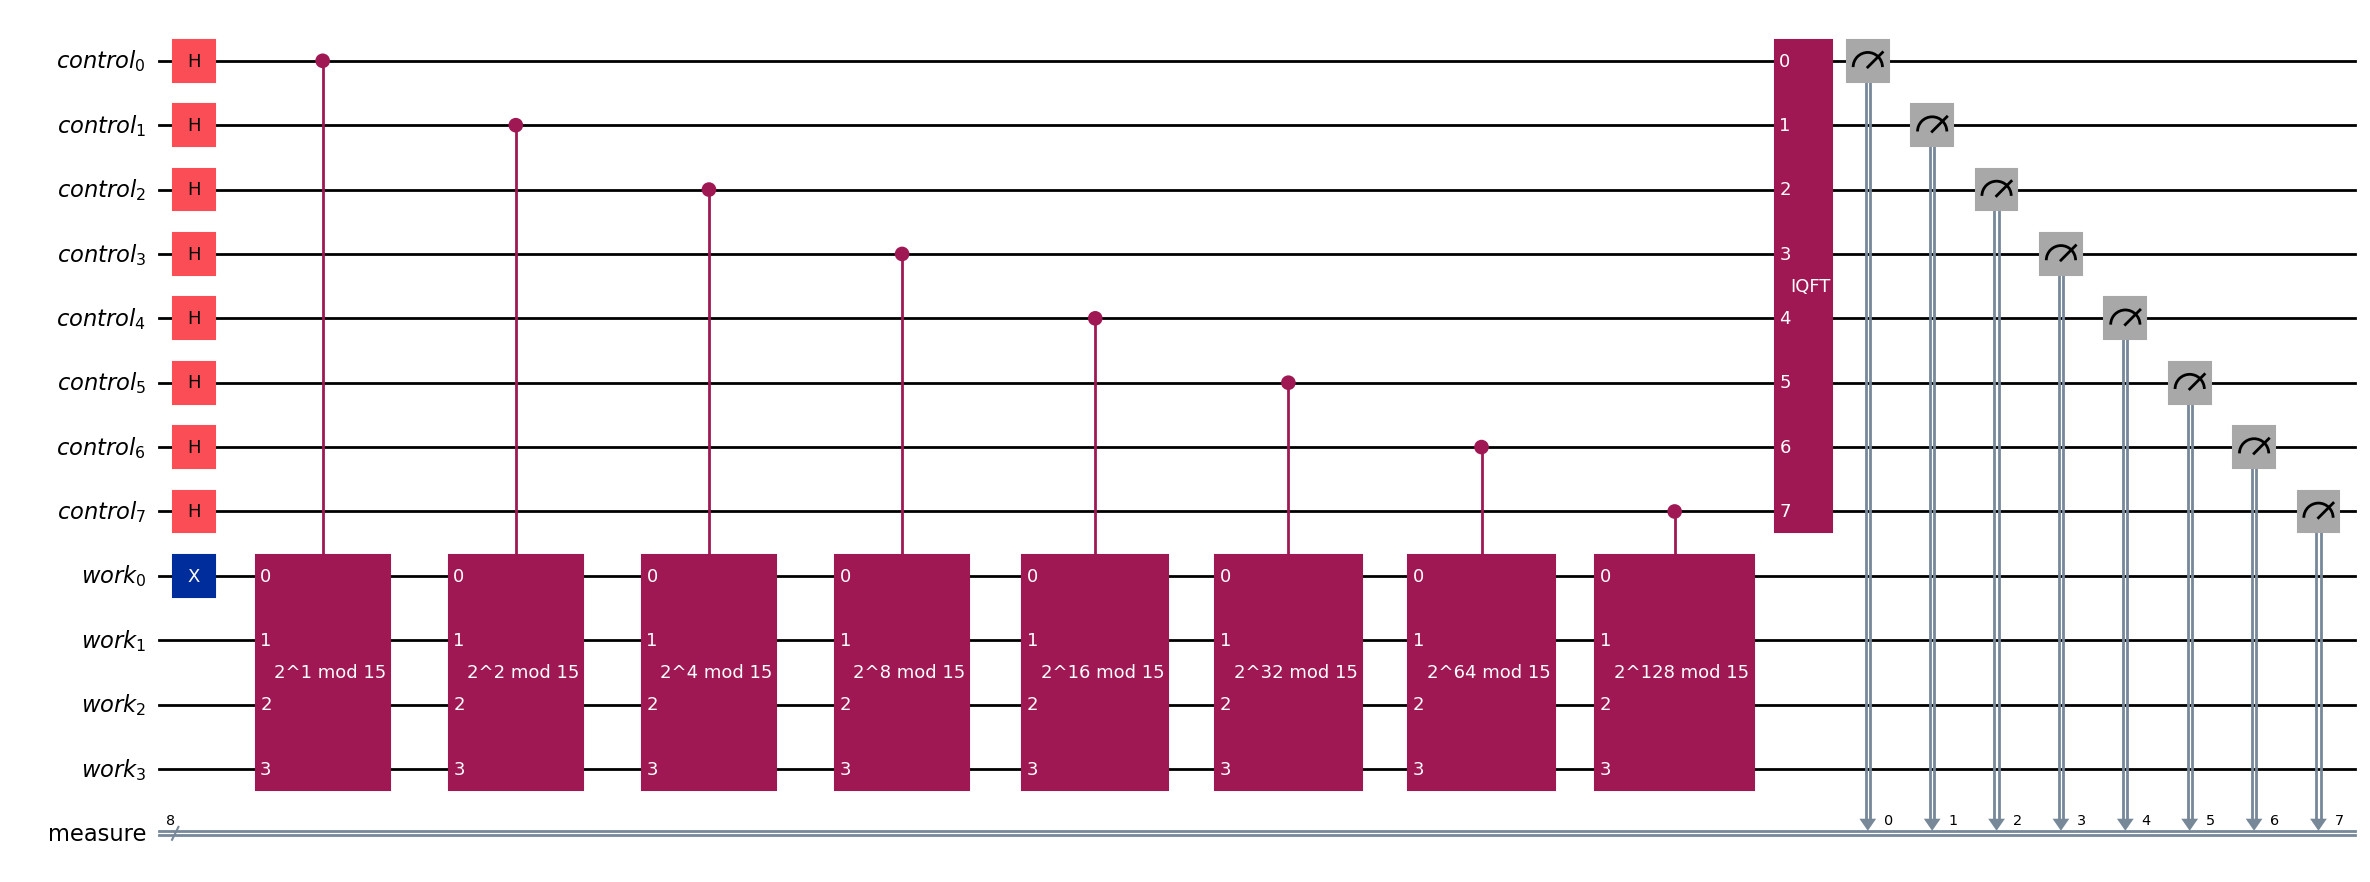

In [93]:
# Measure circuit
qc_shor.measure(range(n_control), range(n_control))
qc_shor.draw('mpl',fold=-1)  # -1 means 'do not fold'

In [ ]:
# Simulate
simulator = AerSimulator()
compiled_qc_shor = transpile(qc_shor, simulator)
result = simulator.run(compiled_qc_shor, shots=1000).result()
counts = result.get_counts()

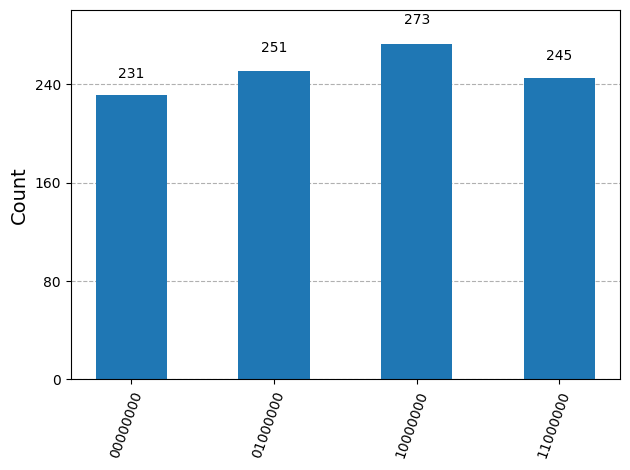

In [95]:
plot_histogram(counts)

In [96]:
import pandas as pd

In [ ]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_control)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",f"{decimal}/{2**n_control} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  00000000(bin) =   0(dec)    0/256 = 0.00
1  11000000(bin) = 192(dec)  192/256 = 0.75
2  10000000(bin) = 128(dec)  128/256 = 0.50
3  01000000(bin) =  64(dec)   64/256 = 0.25


In [ ]:
from fractions import Fraction

In [ ]:
rows = []
candidate = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)  # Find the factional form using continued fractions algorithm
    candidate.append(frac.denominator)
    rows.append([phase,
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.75      3/4            4
2   0.50      1/2            2
3   0.25      1/4            4


In [ ]:
# Factor N
for r in candidate:
    print(f"For r = {r}")
    if r % 2 == 0:
        candidates = [np.gcd(a ** (r // 2) - 1, N), np.gcd(a ** (r // 2) + 1, N)]
        print("Factors of 15:", [c for c in candidates if c not in [1, N]])
    else:
        print("Period 'r' is odd. Try another 'a'.")

For r = 1
Period 'r' is odd. Try another 'a'.
For r = 4
Factors of 15: [3, 5]
For r = 2
Factors of 15: [3]
For r = 4
Factors of 15: [3, 5]


Before starting the below problem, read briefly how the RSA protocol and what processes are followed by the sender to encrpt the message, by the recipient to decrypt the message and how can any adversary intercept the message and 'hack' the communication channel. 

*Problem - Breaking Simplified RSA protocol with Shor’s Algorithm*

You are a quantum cryptanalyst tasked with intercepting a secret message encrypted using a simplified RSA-like protocol. The sender has published their public key (N=15, e=7), and you’ve intercepted the ciphertext [14, 9, 12, 5]. Your mission is to factorize N using Shor’s algorithm to recover the private key d and decrypt the message to reveal the hidden word by following the steps below:
1. Since you know that N=15 (as it is part of the public key), factorize it (using a=7) to obtain p and q such that p*q = 15.
2. Given p and q, compute $\phi(N)$ = (p-1)(q-1).
3. Solve for d such that e * d ≡ 1 mod $\phi(N)$, we know e as it is part of the public key. (Check online if there is a method in python through which we can directly obtain d from the above equation)
4. The ciphertext (c) [14, 9, 12, 5] was encrypted as c = $m^e$ mod 15, where m maps letters to numbers (A=1, B=2, C=3 ..., N=14) (As N is 15, I could only use  the first 14 letters). You can decrypt each number using m = $c^d$ mod 15. 
5. Map the results back to letters to reveal the secret word.